## Introducción al proyecto
En el presente proyecto se trabajará con un dataset de automóviles que contiene información detallada sobre características técnicas, de uso y de mercado de una amplia variedad de vehículos. El análisis se centrará en variables como la potencia del motor, el peso, el tipo de tracción, la eficiencia de combustible, las emisiones de CO2, el año de fabricación, el tipo de combustible, entre otras.

Como primer paso, se realizará un análisis exploratorio de datos (EDA) para comprender la estructura del dataset, identificar patrones, detectar valores atípicos y ausentes, y visualizar la distribución de las variables más relevantes. Este análisis permitirá sentar las bases para la correcta preparación de los datos y la selección de las variables más influyentes.

El objetivo final del proyecto es construir un modelo de machine learning capaz de predecir el precio de un auto a partir de sus características técnicas y de mercado. Se evaluará el desempeño del modelo y se analizará la importancia de cada variable en la predicción del precio, con el fin de obtener conclusiones útiles para el sector automotriz y la toma de decisiones comerciales.

Como primera medida imprtamos las librerias que nos van a servir para nuestro analisis

In [190]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn


vemos las primeras filas del df para saber donde estamos parados

In [191]:
df=pd.read_csv('../data/datasetautostop.csv')
display(df.head())

,Brand,Model,Year,Country,Condition,Engine_Size,Horsepower,Torque,Weight,Top_Speed,...,Mileage,Popularity,Safety_Rating,Number_of_Owners,Market_Demand,Insurance_Cost,Production_Units,Log_Price,Log_Mileage,Modification
0,Nissan,720S,2006,Asia,used,3.7,420,705,1785,238,...,96664,Low,2,4,Medium,13410,5000,11.309352,11.479007,V-Spec
1,McLaren,911 Turbo S,2009,Europe,new,5.3,1104,766,992,386,...,159630,High,2,2,Medium,10795,1000,12.639334,11.980620,NaN
2,Chevrolet,M4 Competition,2009,USA,new,5.5,153,1573,2022,397,...,111496,High,1,2,Low,1716,20000,12.948902,11.621753,NaN
3,Bugatti,Chiron,1982,Asia,used,5.4,544,1009,1091,151,...,217228,High,2,4,Medium,11618,20000,11.725542,12.288707,NaN
4,Nissan,Chiron,2022,Europe,new,2.4,980,693,1232,385,...,150318,Low,3,2,Medium,11324,100000,11.229289,11.920515,NaN


Convertimos la columna year en formato fecha con datetime

In [192]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

A continuacion nos preparamos para el analisis y como es imposible analisar año por año lo que hacemos es agrupar los años por decadas

In [193]:
def agrupar_por_decada(df):
   
    # Asegurarse de que 'Year' es tipo datetime
    if not np.issubdtype(df['Year'].dtype, np.datetime64):
        df['Year'] = pd.to_datetime(df['Year'], format='%Y')
    # Extraer el año como entero
    years = df['Year'].dt.year
    # Calcular la década
    df['decada'] = (years // 10) * 10
    df['decada'] = df['decada'].astype(str) + "s"
    return df

# Aplicar la función al DataFrame
df = agrupar_por_decada(df)
display(df[['Year', 'decada']].head())

,Year,decada
0,2006-01-01,2000s
1,2009-01-01,2000s
2,2009-01-01,2000s
3,1982-01-01,1980s
4,2022-01-01,2020s


Realizamos un informe de calidad de datos para saber todo las condiciones que tiene nuestro df

In [194]:
# Informe de calidad de datos del DataFrame
def informe_calidad_datos(df):
    print('--- INFORME DE CALIDAD DE DATOS ---')
    print('\nDimensiones del DataFrame:')
    print(f'Filas: {df.shape[0]}, Columnas: {df.shape[1]}')
    print('\nTipos de variables:')
    print(df.dtypes)
    print('\nValores nulos por columna:')
    print(df.isnull().sum())
    print('\nPorcentaje de valores nulos por columna:')
    print((df.isnull().mean()*100).round(2))
    print('\nCantidad de filas duplicadas:')
    print(df.duplicated().sum())
    print('\nEstadísticas descriptivas (numéricas):')
    print(df.describe().T)
    print('\nEstadísticas descriptivas (categóricas):')
    print(df.describe(include=['object', 'category']).T)
    print('\nValores únicos por columna:')
    print(df.nunique())
    print('\n--- FIN DEL INFORME ---')

# Ejecutar el informe de calidad de datos
informe_calidad_datos(df)

--- INFORME DE CALIDAD DE DATOS ---

Dimensiones del DataFrame:
Filas: 5000, Columnas: 28

Tipos de variables:
Brand                         object
Model                         object
Year                  datetime64[ns]
Country                       object
Condition                     object
Engine_Size                  float64
Horsepower                     int64
Torque                         int64
Weight                         int64
Top_Speed                      int64
Acceleration_0_100           float64
Fuel_Type                     object
Drivetrain                    object
Transmission                  object
Fuel_Efficiency              float64
CO2_Emissions                  int64
Price                          int64
Mileage                        int64
Popularity                    object
Safety_Rating                  int64
Number_of_Owners               int64
Market_Demand                 object
Insurance_Cost                 int64
Production_Units               int64
L

Como la columna 'modification' tenia un alto porcentaje de valores nulos, y no nos era de suma importancia para nuestro modelo decidi eliminarla

In [195]:

df = df.drop(columns=['Modification'])

     ANÁLISIS DE CALIDAD DE LA VARIABLE OBJETIVO: PRICE

📊 1. INFORMACIÓN BÁSICA:
   Tipo de dato: int64
   Total de registros: 5,000

🔍 2. VALORES NULOS Y FALTANTES:
   Valores nulos: 0 (0.00%)
   ✅ No hay valores nulos

💰 3. VALORES CERO Y NEGATIVOS:
   Valores igual a cero: 0
   Valores negativos: 0
   ✅ Todos los precios son positivos

📈 4. ESTADÍSTICAS DESCRIPTIVAS:
   Media: $262,067.33
   Mediana: $265,213.50
   Desviación estándar: $137,678.80
   Mínimo: $20,014.00
   Máximo: $499,991.00
   Rango: $479,977.00

   Cuartil 25%: $143,710.75
   Cuartil 50% (Mediana): $265,213.50
   Cuartil 75%: $380,923.50
   Rango Intercuartílico (IQR): $237,212.75

🔎 5. DETECCIÓN DE OUTLIERS (Método IQR):
   Límite inferior: $-212,108.38
   Límite superior: $736,742.62
   Outliers inferiores: 0
   Outliers superiores: 0
   Total de outliers: 0 (0.00%)
   ✅ No se detectaron outliers

📊 6. DISTRIBUCIÓN DE LA VARIABLE:
   Asimetría (Skewness): -0.0397
   Curtosis (Kurtosis): -1.1854
   ✅ Distribució

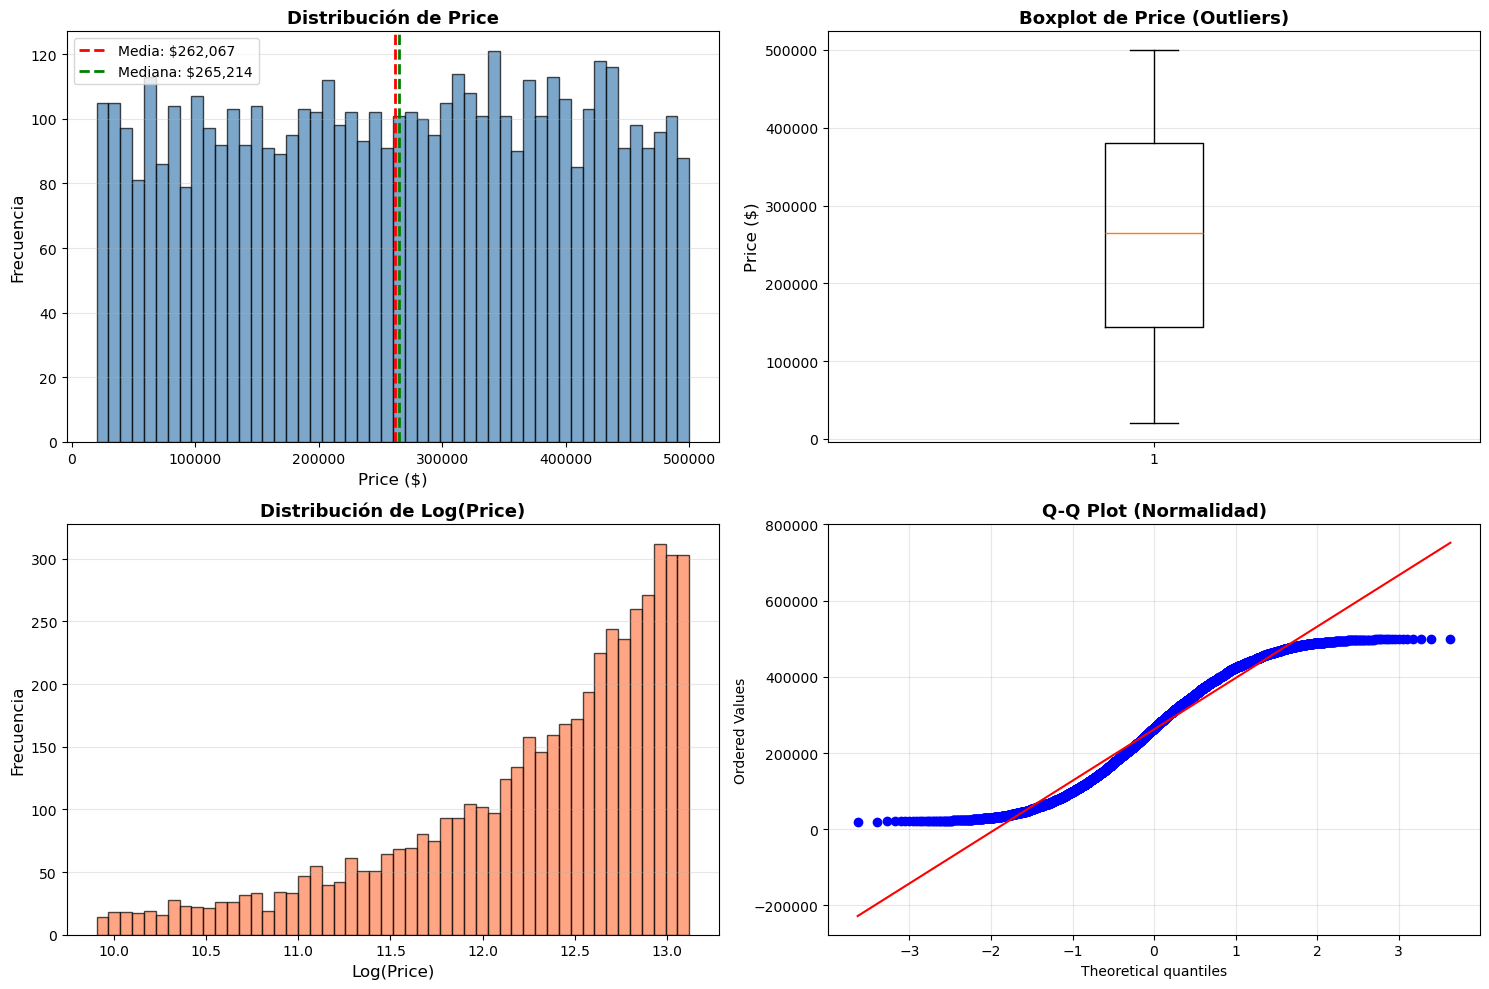


                    RESUMEN Y RECOMENDACIONES

✅ CALIDAD DE DATOS: EXCELENTE
   No se detectaron problemas significativos en la variable Price

                    FIN DEL ANÁLISIS


In [196]:
# ========================================
# ANÁLISIS DE CALIDAD DE DATOS: PRICE
# ========================================

print('='*70)
print('     ANÁLISIS DE CALIDAD DE LA VARIABLE OBJETIVO: PRICE')
print('='*70)

# 1. INFORMACIÓN BÁSICA
print('\n📊 1. INFORMACIÓN BÁSICA:')
print(f'   Tipo de dato: {df["Price"].dtype}')
print(f'   Total de registros: {len(df["Price"]):,}')

# 2. VALORES NULOS
print('\n🔍 2. VALORES NULOS Y FALTANTES:')
nulos_price = df['Price'].isnull().sum()
porcentaje_nulos = (nulos_price / len(df)) * 100
print(f'   Valores nulos: {nulos_price} ({porcentaje_nulos:.2f}%)')

if nulos_price > 0:
    print('   ⚠️  ¡ATENCIÓN! Se detectaron valores nulos en Price')
else:
    print('   ✅ No hay valores nulos')

# 3. VALORES CERO Y NEGATIVOS
print('\n💰 3. VALORES CERO Y NEGATIVOS:')
valores_cero = (df['Price'] == 0).sum()
valores_negativos = (df['Price'] < 0).sum()
print(f'   Valores igual a cero: {valores_cero}')
print(f'   Valores negativos: {valores_negativos}')

if valores_cero > 0 or valores_negativos > 0:
    print('   ⚠️  ¡ATENCIÓN! Hay valores cero o negativos (poco realista para precios)')
else:
    print('   ✅ Todos los precios son positivos')

# 4. ESTADÍSTICAS DESCRIPTIVAS
print('\n📈 4. ESTADÍSTICAS DESCRIPTIVAS:')
print(f'   Media: ${df["Price"].mean():,.2f}')
print(f'   Mediana: ${df["Price"].median():,.2f}')
print(f'   Desviación estándar: ${df["Price"].std():,.2f}')
print(f'   Mínimo: ${df["Price"].min():,.2f}')
print(f'   Máximo: ${df["Price"].max():,.2f}')
print(f'   Rango: ${df["Price"].max() - df["Price"].min():,.2f}')

# Cuartiles
q25 = df['Price'].quantile(0.25)
q50 = df['Price'].quantile(0.50)
q75 = df['Price'].quantile(0.75)
iqr = q75 - q25

print(f'\n   Cuartil 25%: ${q25:,.2f}')
print(f'   Cuartil 50% (Mediana): ${q50:,.2f}')
print(f'   Cuartil 75%: ${q75:,.2f}')
print(f'   Rango Intercuartílico (IQR): ${iqr:,.2f}')

# 5. OUTLIERS
print('\n🔎 5. DETECCIÓN DE OUTLIERS (Método IQR):')
limite_inferior = q25 - 1.5 * iqr
limite_superior = q75 + 1.5 * iqr

outliers_inferiores = (df['Price'] < limite_inferior).sum()
outliers_superiores = (df['Price'] > limite_superior).sum()
total_outliers = outliers_inferiores + outliers_superiores
porcentaje_outliers = (total_outliers / len(df)) * 100

print(f'   Límite inferior: ${limite_inferior:,.2f}')
print(f'   Límite superior: ${limite_superior:,.2f}')
print(f'   Outliers inferiores: {outliers_inferiores}')
print(f'   Outliers superiores: {outliers_superiores}')
print(f'   Total de outliers: {total_outliers} ({porcentaje_outliers:.2f}%)')

if total_outliers > 0:
    print(f'   ⚠️  Se detectaron {total_outliers} outliers')
else:
    print('   ✅ No se detectaron outliers')

# 6. DISTRIBUCIÓN
print('\n📊 6. DISTRIBUCIÓN DE LA VARIABLE:')
print(f'   Asimetría (Skewness): {df["Price"].skew():.4f}')
print(f'   Curtosis (Kurtosis): {df["Price"].kurtosis():.4f}')

if abs(df['Price'].skew()) < 0.5:
    print('   ✅ Distribución aproximadamente simétrica')
elif abs(df['Price'].skew()) < 1:
    print('   ⚠️  Distribución moderadamente asimétrica')
else:
    print('   ❌ Distribución muy asimétrica')

# 7. VALORES INFINITOS
print('\n∞ 7. VALORES INFINITOS:')
infinitos = np.isinf(df['Price']).sum()
print(f'   Valores infinitos: {infinitos}')
if infinitos > 0:
    print('   ⚠️  ¡ATENCIÓN! Se detectaron valores infinitos')
else:
    print('   ✅ No hay valores infinitos')

# 8. VISUALIZACIÓN
print('\n📊 8. GENERANDO VISUALIZACIONES...')

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histograma
axes[0, 0].hist(df['Price'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df['Price'].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: ${df["Price"].mean():,.0f}')
axes[0, 0].axvline(df['Price'].median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: ${df["Price"].median():,.0f}')
axes[0, 0].set_xlabel('Price ($)', fontsize=12)
axes[0, 0].set_ylabel('Frecuencia', fontsize=12)
axes[0, 0].set_title('Distribución de Price', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3, axis='y')

# Boxplot
axes[0, 1].boxplot(df['Price'].dropna(), vert=True)
axes[0, 1].set_ylabel('Price ($)', fontsize=12)
axes[0, 1].set_title('Boxplot de Price (Outliers)', fontsize=13, fontweight='bold')
axes[0, 1].grid(alpha=0.3, axis='y')

# Logaritmo de Price (para ver mejor la distribución)
axes[1, 0].hist(np.log1p(df['Price']), bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Log(Price)', fontsize=12)
axes[1, 0].set_ylabel('Frecuencia', fontsize=12)
axes[1, 0].set_title('Distribución de Log(Price)', fontsize=13, fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='y')

# Q-Q Plot (para verificar normalidad)
from scipy import stats
stats.probplot(df['Price'].dropna(), dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Normalidad)', fontsize=13, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 9. RESUMEN Y RECOMENDACIONES
print('\n' + '='*70)
print('                    RESUMEN Y RECOMENDACIONES')
print('='*70 + '\n')

# Evaluación general
problemas = []
if nulos_price > 0:
    problemas.append(f'• Valores nulos: {nulos_price} registros')
if valores_cero > 0:
    problemas.append(f'• Valores iguales a cero: {valores_cero} registros')
if valores_negativos > 0:
    problemas.append(f'• Valores negativos: {valores_negativos} registros')
if infinitos > 0:
    problemas.append(f'• Valores infinitos: {infinitos} registros')
if porcentaje_outliers > 5:
    problemas.append(f'• Alto porcentaje de outliers: {porcentaje_outliers:.2f}%')
if abs(df['Price'].skew()) > 1:
    problemas.append('• Distribución muy asimétrica')

if len(problemas) == 0:
    print('✅ CALIDAD DE DATOS: EXCELENTE')
    print('   No se detectaron problemas significativos en la variable Price')
else:
    print('⚠️  PROBLEMAS DETECTADOS:')
    for problema in problemas:
        print(f'   {problema}')
    
    print('\n📋 RECOMENDACIONES:')
    if nulos_price > 0:
        print('   1. Imputar o eliminar registros con valores nulos')
    if valores_cero > 0 or valores_negativos > 0:
        print('   2. Eliminar o corregir valores cero/negativos (no realistas)')
    if porcentaje_outliers > 5:
        print('   3. Considerar tratamiento de outliers (eliminar o transformar)')
    if abs(df['Price'].skew()) > 1:
        print('   4. Aplicar transformación logarítmica para normalizar')

print('\n' + '='*70)
print('                    FIN DEL ANÁLISIS')
print('='*70)

In [197]:
df.columns

Index(['Brand', 'Model', 'Year', 'Country', 'Condition', 'Engine_Size',
       'Horsepower', 'Torque', 'Weight', 'Top_Speed', 'Acceleration_0_100',
       'Fuel_Type', 'Drivetrain', 'Transmission', 'Fuel_Efficiency',
       'CO2_Emissions', 'Price', 'Mileage', 'Popularity', 'Safety_Rating',
       'Number_of_Owners', 'Market_Demand', 'Insurance_Cost',
       'Production_Units', 'Log_Price', 'Log_Mileage', 'decada'],
      dtype='object')

## Análisis de Calidad de la Variable Objetivo: Price
A continuación, realizamos un análisis exhaustivo de la variable objetivo **Price** para verificar su calidad y detectar posibles problemas antes de entrenar el modelo.

## Análisis de Calidad de la Variable Log_Price
A continuación, realizamos un análisis exhaustivo de la variable transformada **Log_Price** para verificar su calidad, detectar outliers y valores nulos antes de usarla en el modelo.

     ANÁLISIS DE CALIDAD DE LA VARIABLE LOG_PRICE

✅ La columna Log_Price existe en el dataframe

📊 1. INFORMACIÓN BÁSICA:
   Tipo de dato: float64
   Total de registros: 5,000

🔍 2. VALORES NULOS Y FALTANTES:
   Valores nulos: 0 (0.00%)
   ✅ No hay valores nulos

∞ 3. VALORES INFINITOS Y NEGATIVOS:
   Valores infinitos: 0
   Valores negativos: 0
   Valores igual a cero: 0
   ✅ No hay valores infinitos
   ✅ No hay valores negativos

📈 4. ESTADÍSTICAS DESCRIPTIVAS:
   Media: 12.2670
   Mediana: 12.4883
   Desviación estándar: 0.7411
   Mínimo: 9.9042
   Máximo: 13.1223
   Rango: 3.2181

   Cuartil 25%: 11.8756
   Cuartil 50% (Mediana): 12.4883
   Cuartil 75%: 12.8504
   Rango Intercuartílico (IQR): 0.9748

🔎 5. DETECCIÓN DE OUTLIERS (Método IQR):
   Límite inferior: 10.4134
   Límite superior: 14.3125
   Outliers inferiores: 150
   Outliers superiores: 0
   Total de outliers: 150 (3.00%)
   ⚠️  Se detectaron 150 outliers

📊 6. DISTRIBUCIÓN DE LA VARIABLE:
   Asimetría (Skewness): -1.113

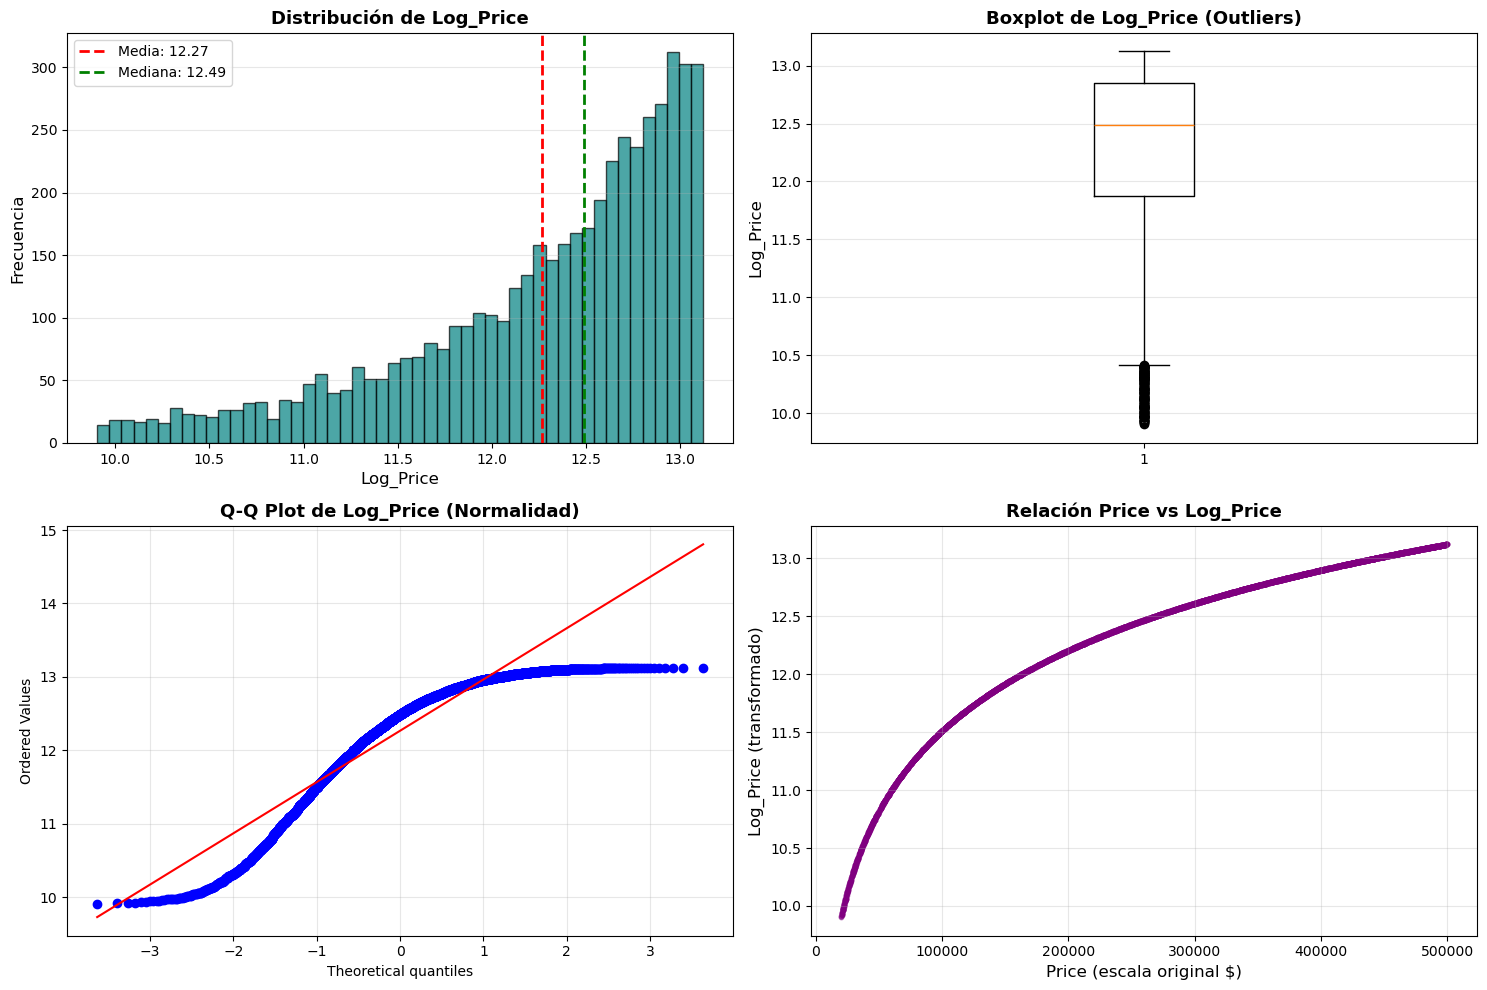


                    RESUMEN Y RECOMENDACIONES

⚠️  PROBLEMAS DETECTADOS:
   • Distribución muy asimétrica (revisar transformación)

📋 RECOMENDACIONES:

📊 COMPARACIÓN CON PRICE ORIGINAL:
   Asimetría Price:     -0.0397
   Asimetría Log_Price: -1.1133
   ⚠️  La transformación NO mejoró significativamente la simetría

                    FIN DEL ANÁLISIS DE LOG_PRICE


In [198]:
# ========================================
# ANÁLISIS DE CALIDAD DE DATOS: LOG_PRICE
# ========================================

print('='*70)
print('     ANÁLISIS DE CALIDAD DE LA VARIABLE LOG_PRICE')
print('='*70)

# Verificar si Log_Price existe en el dataframe
if 'Log_Price' not in df.columns:
    print('\n⚠️  ADVERTENCIA: La columna Log_Price NO existe en el dataframe')
    print('   Creando Log_Price a partir de Price...\n')
    df['Log_Price'] = np.log1p(df['Price'])
    print('✅ Columna Log_Price creada exitosamente usando: np.log1p(Price)')
else:
    print('\n✅ La columna Log_Price existe en el dataframe')

# 1. INFORMACIÓN BÁSICA
print('\n📊 1. INFORMACIÓN BÁSICA:')
print(f'   Tipo de dato: {df["Log_Price"].dtype}')
print(f'   Total de registros: {len(df["Log_Price"]):,}')

# 2. VALORES NULOS
print('\n🔍 2. VALORES NULOS Y FALTANTES:')
nulos_log_price = df['Log_Price'].isnull().sum()
porcentaje_nulos_log = (nulos_log_price / len(df)) * 100
print(f'   Valores nulos: {nulos_log_price} ({porcentaje_nulos_log:.2f}%)')

if nulos_log_price > 0:
    print('   ⚠️  ¡ATENCIÓN! Se detectaron valores nulos en Log_Price')
else:
    print('   ✅ No hay valores nulos')

# 3. VALORES INFINITOS Y NEGATIVOS
print('\n∞ 3. VALORES INFINITOS Y NEGATIVOS:')
valores_infinitos = np.isinf(df['Log_Price']).sum()
valores_negativos_log = (df['Log_Price'] < 0).sum()
valores_cero_log = (df['Log_Price'] == 0).sum()

print(f'   Valores infinitos: {valores_infinitos}')
print(f'   Valores negativos: {valores_negativos_log}')
print(f'   Valores igual a cero: {valores_cero_log}')

if valores_infinitos > 0:
    print('   ⚠️  ¡ATENCIÓN! Hay valores infinitos (revisar transformación)')
else:
    print('   ✅ No hay valores infinitos')

if valores_negativos_log > 0:
    print('   ⚠️  ¡ATENCIÓN! Hay valores negativos (revisar datos originales)')
else:
    print('   ✅ No hay valores negativos')

# 4. ESTADÍSTICAS DESCRIPTIVAS
print('\n📈 4. ESTADÍSTICAS DESCRIPTIVAS:')
print(f'   Media: {df["Log_Price"].mean():.4f}')
print(f'   Mediana: {df["Log_Price"].median():.4f}')
print(f'   Desviación estándar: {df["Log_Price"].std():.4f}')
print(f'   Mínimo: {df["Log_Price"].min():.4f}')
print(f'   Máximo: {df["Log_Price"].max():.4f}')
print(f'   Rango: {df["Log_Price"].max() - df["Log_Price"].min():.4f}')

# Cuartiles
q25_log = df['Log_Price'].quantile(0.25)
q50_log = df['Log_Price'].quantile(0.50)
q75_log = df['Log_Price'].quantile(0.75)
iqr_log = q75_log - q25_log

print(f'\n   Cuartil 25%: {q25_log:.4f}')
print(f'   Cuartil 50% (Mediana): {q50_log:.4f}')
print(f'   Cuartil 75%: {q75_log:.4f}')
print(f'   Rango Intercuartílico (IQR): {iqr_log:.4f}')

# 5. OUTLIERS (Método IQR)
print('\n🔎 5. DETECCIÓN DE OUTLIERS (Método IQR):')
limite_inferior_log = q25_log - 1.5 * iqr_log
limite_superior_log = q75_log + 1.5 * iqr_log

outliers_inferiores_log = (df['Log_Price'] < limite_inferior_log).sum()
outliers_superiores_log = (df['Log_Price'] > limite_superior_log).sum()
total_outliers_log = outliers_inferiores_log + outliers_superiores_log
porcentaje_outliers_log = (total_outliers_log / len(df)) * 100

print(f'   Límite inferior: {limite_inferior_log:.4f}')
print(f'   Límite superior: {limite_superior_log:.4f}')
print(f'   Outliers inferiores: {outliers_inferiores_log}')
print(f'   Outliers superiores: {outliers_superiores_log}')
print(f'   Total de outliers: {total_outliers_log} ({porcentaje_outliers_log:.2f}%)')

if total_outliers_log > 0:
    print(f'   ⚠️  Se detectaron {total_outliers_log} outliers')
    # Mostrar algunos ejemplos de outliers
    if outliers_superiores_log > 0:
        outliers_superiores_valores = df[df['Log_Price'] > limite_superior_log]['Log_Price'].head(5)
        print(f'\n   📋 Ejemplos de outliers superiores:')
        for idx, val in outliers_superiores_valores.items():
            precio_original = np.expm1(val)
            print(f'      Log_Price: {val:.4f} (Price original: ${precio_original:,.2f})')
else:
    print('   ✅ No se detectaron outliers')

# 6. DISTRIBUCIÓN
print('\n📊 6. DISTRIBUCIÓN DE LA VARIABLE:')
print(f'   Asimetría (Skewness): {df["Log_Price"].skew():.4f}')
print(f'   Curtosis (Kurtosis): {df["Log_Price"].kurtosis():.4f}')

if abs(df['Log_Price'].skew()) < 0.5:
    print('   ✅ Distribución aproximadamente simétrica')
elif abs(df['Log_Price'].skew()) < 1:
    print('   ⚠️  Distribución moderadamente asimétrica')
else:
    print('   ❌ Distribución muy asimétrica')

# 7. CORRELACIÓN CON PRICE ORIGINAL
print('\n🔗 7. CORRELACIÓN CON PRICE ORIGINAL:')
if 'Price' in df.columns:
    correlacion = df[['Price', 'Log_Price']].corr().iloc[0, 1]
    print(f'   Correlación Price vs Log_Price: {correlacion:.6f}')
    print('   ✅ Transformación logarítmica aplicada correctamente')

# 8. VISUALIZACIÓN
print('\n📊 8. GENERANDO VISUALIZACIONES...')

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histograma de Log_Price
axes[0, 0].hist(df['Log_Price'].dropna(), bins=50, color='teal', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df['Log_Price'].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {df["Log_Price"].mean():.2f}')
axes[0, 0].axvline(df['Log_Price'].median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: {df["Log_Price"].median():.2f}')
axes[0, 0].set_xlabel('Log_Price', fontsize=12)
axes[0, 0].set_ylabel('Frecuencia', fontsize=12)
axes[0, 0].set_title('Distribución de Log_Price', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3, axis='y')

# Boxplot de Log_Price
axes[0, 1].boxplot(df['Log_Price'].dropna(), vert=True)
axes[0, 1].set_ylabel('Log_Price', fontsize=12)
axes[0, 1].set_title('Boxplot de Log_Price (Outliers)', fontsize=13, fontweight='bold')
axes[0, 1].grid(alpha=0.3, axis='y')

# Q-Q Plot para verificar normalidad
from scipy import stats
stats.probplot(df['Log_Price'].dropna(), dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot de Log_Price (Normalidad)', fontsize=13, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Comparación Price vs Log_Price (escala original)
if 'Price' in df.columns:
    axes[1, 1].scatter(df['Price'], df['Log_Price'], alpha=0.5, s=10, color='purple')
    axes[1, 1].set_xlabel('Price (escala original $)', fontsize=12)
    axes[1, 1].set_ylabel('Log_Price (transformado)', fontsize=12)
    axes[1, 1].set_title('Relación Price vs Log_Price', fontsize=13, fontweight='bold')
    axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 9. RESUMEN Y RECOMENDACIONES
print('\n' + '='*70)
print('                    RESUMEN Y RECOMENDACIONES')
print('='*70 + '\n')

# Evaluación general
problemas_log = []
if nulos_log_price > 0:
    problemas_log.append(f'• Valores nulos: {nulos_log_price} registros')
if valores_infinitos > 0:
    problemas_log.append(f'• Valores infinitos: {valores_infinitos} registros')
if valores_negativos_log > 0:
    problemas_log.append(f'• Valores negativos: {valores_negativos_log} registros')
if porcentaje_outliers_log > 5:
    problemas_log.append(f'• Alto porcentaje de outliers: {porcentaje_outliers_log:.2f}%')
if abs(df['Log_Price'].skew()) > 1:
    problemas_log.append('• Distribución muy asimétrica (revisar transformación)')

if len(problemas_log) == 0:
    print('✅ CALIDAD DE DATOS: EXCELENTE')
    print('   No se detectaron problemas significativos en la variable Log_Price')
    print('   ✅ La transformación logarítmica mejoró la distribución')
    print('   ✅ Variable lista para usar en modelos de Machine Learning')
else:
    print('⚠️  PROBLEMAS DETECTADOS:')
    for problema in problemas_log:
        print(f'   {problema}')
    
    print('\n📋 RECOMENDACIONES:')
    if nulos_log_price > 0:
        print('   1. Imputar o eliminar registros con valores nulos en Log_Price')
    if valores_infinitos > 0:
        print('   2. Revisar valores infinitos (posibles precios = 0 en datos originales)')
    if porcentaje_outliers_log > 5:
        print('   3. Considerar tratamiento de outliers en Log_Price')
    if valores_negativos_log > 0:
        print('   4. Revisar valores negativos (posibles errores en Price original)')

# Comparación con Price original
print('\n📊 COMPARACIÓN CON PRICE ORIGINAL:')
if 'Price' in df.columns:
    skew_price = df['Price'].skew()
    skew_log = df['Log_Price'].skew()
    print(f'   Asimetría Price:     {skew_price:.4f}')
    print(f'   Asimetría Log_Price: {skew_log:.4f}')
    mejora = abs(skew_price) - abs(skew_log)
    if mejora > 0:
        print(f'   ✅ La transformación logarítmica MEJORÓ la simetría en {mejora:.4f}')
    else:
        print(f'   ⚠️  La transformación NO mejoró significativamente la simetría')

print('\n' + '='*70)
print('                    FIN DEL ANÁLISIS DE LOG_PRICE')
print('='*70)

## GRAFICO I
Este grafico esta diseñado con la finalidad de saber en que epoca se fabricaron mas autos.

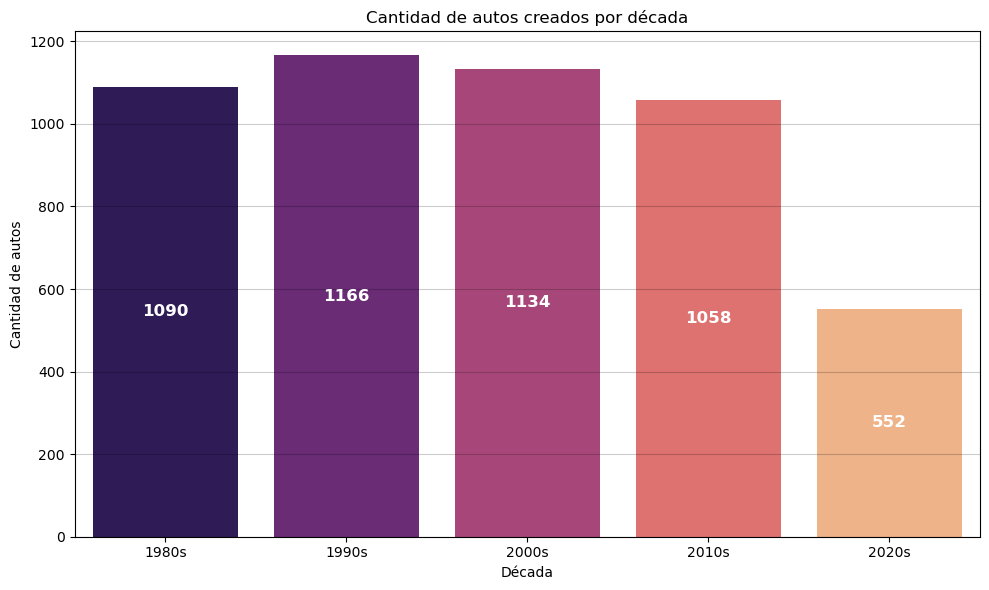

In [199]:
# Gráfico de barras con seaborn: cantidad de autos por década con valores en el centro
conteo_decadas = df['decada'].value_counts().sort_index()
plt.figure(figsize=(10,6))
bars = sns.barplot(x=conteo_decadas.index, y=conteo_decadas.values,hue=conteo_decadas.index, palette="magma", legend=False)
plt.xlabel('Década')
plt.ylabel('Cantidad de autos')
plt.title('Cantidad de autos creados por década')
plt.grid(axis='y', color='black', alpha=0.2)
plt.tight_layout()

for bar, valor in zip(bars.patches, conteo_decadas.values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() / 2,
        str(valor),
        ha='center',
        va='center',
        color='white',
        fontweight='bold',
        fontsize=12
    )

plt.show()

### Conclusión del gráfico de autos por década
Como conclusión del primer gráfico podemos ver claramente cómo los años 1990s y 2000s fueron la década donde más autos se fabricaron con respecto a las otras.

## GRAFICO II
Este grafico esta diseñado con la finalidad de saber que tipo de traccion es la mas utilizada en el mundo automovil.

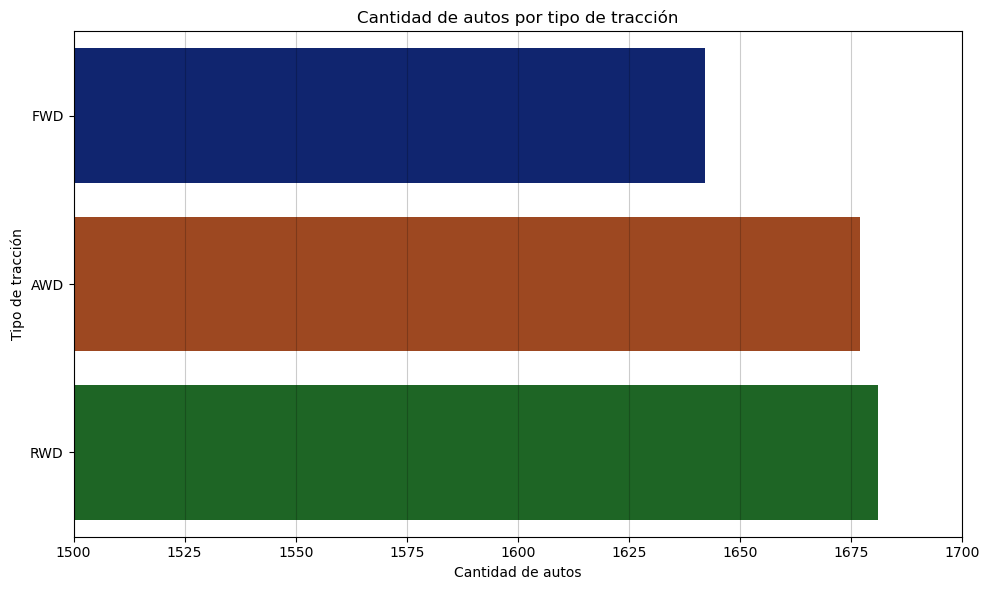

In [200]:
# Gráfico de barras horizontales con seaborn: cantidad de autos por tipo de tracción
conteo_traccion = df['Drivetrain'].value_counts().sort_values()
plt.figure(figsize=(10,6))
bars = sns.barplot(x=conteo_traccion.values, y=conteo_traccion.index,hue=conteo_traccion.values, palette="dark", legend=False)
plt.xlabel('Cantidad de autos')
plt.ylabel('Tipo de tracción')
plt.title('Cantidad de autos por tipo de tracción')
plt.xlim(1500, 1700)  # Limitar el eje X entre 1500 y 1700
plt.grid(axis='x', color='black', alpha=0.2)
plt.tight_layout()
plt.show()

### Conclusión del gráfico de tipo de tracción
Como conclusión del gráfico podemos ver cómo la tracción más utilizada es la RWD (Traccion trasera), seguida por la AWD (Traccion en las 4 ruedas) y por último la FWD (Traccion delantera).

Al tener muchos valores de potencia diferente para cada auto decidi hacer lo mismo que con las decadas y agrupar por grupos de potencias

In [201]:
def clasificar_potencia(df):

    condiciones = [
        df['Horsepower'] <= 593,
        (df['Horsepower'] > 593) & (df['Horsepower'] <= 1057),
        df['Horsepower'] > 1057
    ]
    opciones = ['Potencia baja', 'Potencia media', 'Potencia alta']
    df['Grupo_Potencia'] = np.select(condiciones, opciones, default='Desconocido')
    return df

# Aplicar la función al DataFrame
df = clasificar_potencia(df)
display(df[['Horsepower', 'Grupo_Potencia']].head())

,Horsepower,Grupo_Potencia
0,420,Potencia baja
1,1104,Potencia alta
2,153,Potencia baja
3,544,Potencia baja
4,980,Potencia media


## GRAFICO III
Este grafico esta diseñado con la finalidad de saber la eficiencia de combustible, si fue decendiendo o aumentando a travez del tiempo.

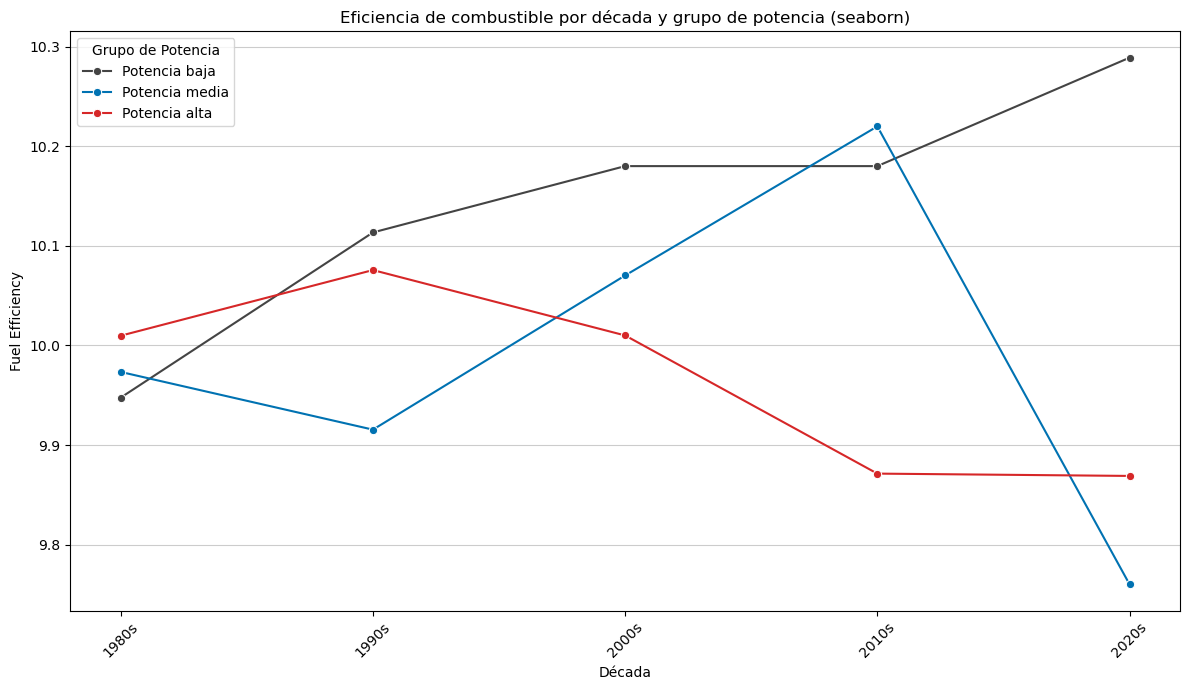

In [202]:
# Gráfico de líneas con seaborn: eficiencia de combustible por década y grupo de potencia
import seaborn as sns
plt.figure(figsize=(12,7))
grupos = ['Potencia baja', 'Potencia media', 'Potencia alta']
colores_grupo = {
    'Potencia baja': '#444444',   # gris oscuro
    'Potencia media': '#0072B2', # azul
    'Potencia alta': '#D62728'   # rojo
}
for grupo in grupos:
    datos_grupo = df[df['Grupo_Potencia'] == grupo]
    promedio = datos_grupo.groupby('decada')['Fuel_Efficiency'].mean().sort_index()
    sns.lineplot(x=promedio.index, y=promedio.values, label=grupo, color=colores_grupo[grupo], marker='o')
plt.xlabel('Década')
plt.ylabel('Fuel Efficiency')
plt.title('Eficiencia de combustible por década y grupo de potencia (seaborn)')
plt.legend(title='Grupo de Potencia')
plt.xticks(rotation=45)
plt.grid(axis='y', color='black', alpha=0.2)
plt.tight_layout()
plt.show()

### Conclusión del gráfico de eficiencia de combustible
Como conclusión del gráfico se puede ver cómo la eficiencia de combustible fue positiva para motores con una Potencia baja, mientras que la eficiencia para Potencia media y Alta fue decayendo a medida que pasa el tiempo.

## GRAFICO IV
Este grafico esta diseñado con la finalidad de saber la contaminacion de CO2, si fue decendiendo o aumentando a travez del tiempo.

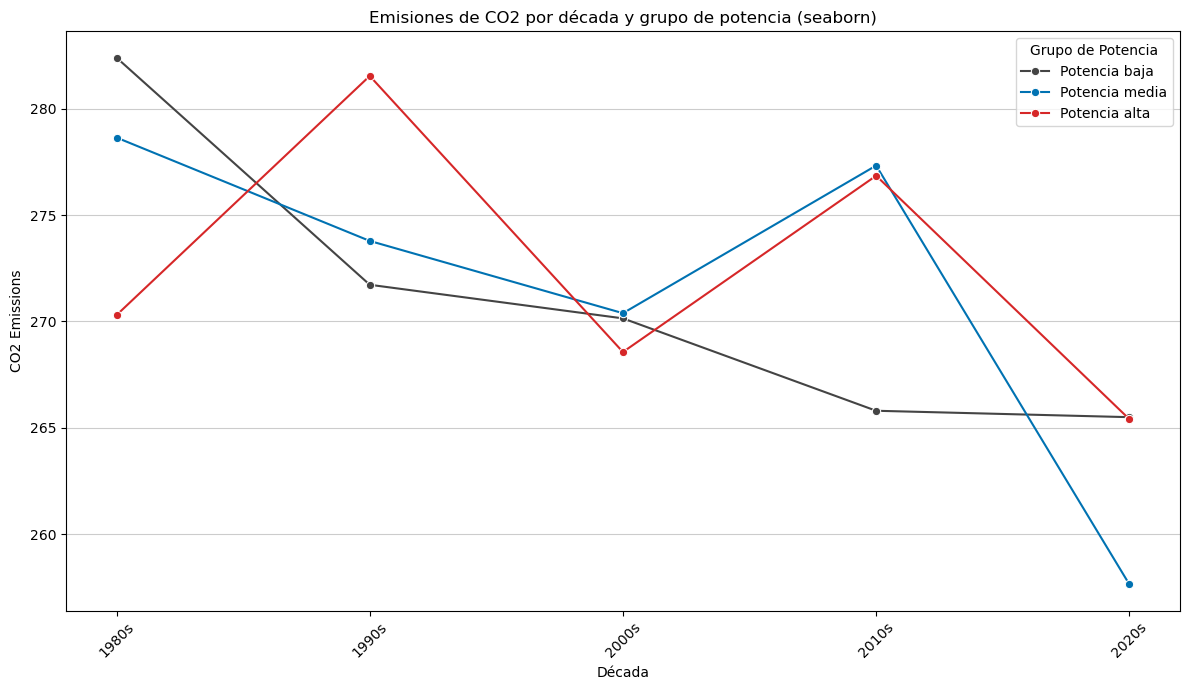

In [203]:
# Gráfico de líneas con seaborn: emisiones de CO2 por década y grupo de potencia
import seaborn as sns
plt.figure(figsize=(12,7))
grupos = ['Potencia baja', 'Potencia media', 'Potencia alta']
colores_grupo = {
    'Potencia baja': '#444444',   # gris oscuro
    'Potencia media': '#0072B2', # azul
    'Potencia alta': '#D62728'   # rojo
}
for grupo in grupos:
    datos_grupo = df[df['Grupo_Potencia'] == grupo]
    promedio = datos_grupo.groupby('decada')['CO2_Emissions'].mean().sort_index()
    sns.lineplot(x=promedio.index, y=promedio.values, label=grupo, color=colores_grupo[grupo], marker='o')
plt.xlabel('Década')
plt.ylabel('CO2 Emissions')
plt.title('Emisiones de CO2 por década y grupo de potencia (seaborn)')
plt.legend(title='Grupo de Potencia')
plt.xticks(rotation=45)
plt.grid(axis='y', color='black', alpha=0.2)
plt.tight_layout()
plt.show()

### Conclusión del gráfico de emisiones de CO2
Como se puede ver en este gráfico, los autos con motores de potencia media son los menos contaminantes actualmente, Estos tuvieron una evolución positiva a lo largo del tiempo logrando contaminar menos al ambiente. Por el contrario, los motores con una Potencia baja y alta, aunque tuvieron una bajada, son más contaminantes que el anterior, aunque siguen siendo valores relativamente bajos.

Una ves terminada la exploracion y interiorizarnos mas en nuestro df, pasamos a la parte donde vamos a empezar con el algoritmo, en este caso voy a usar un algoritmo de regresion lineal, La regresión lineal múltiple es un modelo estadístico que permite estimar y explicar la relación entre una variable dependiente (Y) y dos o más variables independientes (X₁, X₂, …, Xₙ).

 Su objetivo es cuantificar cómo cambia Y cuando cada predictor varía, manteniendo los demás constantes.



Lo que procemos a hacer es preparar los datos para el modelo de regresion, realizamos OHE, en las varialbles 'Drivetrain', 'Fuel_Type' para poder pasar de valores cualitativos a cuantitativos asi elmodelo funciona correctamente

In [204]:
# Crear copias de las variables con sufijo _h
for col in ['Brand', 'Fuel_Type', 'Drivetrain']:
    df[col + '_h'] = df[col].copy()

# One Hot Encoding sobre las nuevas variables
variables_ohe = ['Brand_h', 'Fuel_Type_h', 'Drivetrain_h']
df = pd.get_dummies(df, columns=variables_ohe)

display(df.head())

,Brand,Model,Year,Country,Condition,Engine_Size,Horsepower,Torque,Weight,Top_Speed,...,Brand_h_Lamborghini,Brand_h_McLaren,Brand_h_Nissan,Brand_h_Porsche,Fuel_Type_h_Diesel,Fuel_Type_h_Electric,Fuel_Type_h_Petrol,Drivetrain_h_AWD,Drivetrain_h_FWD,Drivetrain_h_RWD
0,Nissan,720S,2006-01-01,Asia,used,3.7,420,705,1785,238,...,False,False,True,False,True,False,False,False,False,True
1,McLaren,911 Turbo S,2009-01-01,Europe,new,5.3,1104,766,992,386,...,False,True,False,False,False,True,False,False,False,True
2,Chevrolet,M4 Competition,2009-01-01,USA,new,5.5,153,1573,2022,397,...,False,False,False,False,True,False,False,False,True,False
3,Bugatti,Chiron,1982-01-01,Asia,used,5.4,544,1009,1091,151,...,False,False,False,False,False,False,True,False,False,True
4,Nissan,Chiron,2022-01-01,Europe,new,2.4,980,693,1232,385,...,False,False,True,False,False,False,True,True,False,False


In [205]:
df['Log_Price']


0       11.309352
1       12.639334
2       12.948902
3       11.725542
4       11.229289
          ...    
4995    12.423452
4996    12.781219
4997    11.912057
4998    12.473306
4999    11.267536
Name: Log_Price, Length: 5000, dtype: float64

In [206]:
# Verificar las columnas creadas por One Hot Encoding de Brand
columnas_brand = [col for col in df.columns if 'Brand_h_' in col]
print(f'=== ONE HOT ENCODING DE BRAND ===\n')
print(f'Total de marcas únicas: {len(columnas_brand)}')
print(f'\nMarcas codificadas:')
for i, marca in enumerate(sorted(columnas_brand), 1):
    print(f'{i}. {marca.replace("Brand_h_", "")}')

# Visualizar ejemplo de OHE
print(f'\n=== EJEMPLO DE CODIFICACIÓN ===')
print(f'Mostrando columnas Brand originales y sus versiones OHE:')
columnas_mostrar = ['Brand'] + columnas_brand[:5]  # Brand original + primeras 5 columnas OHE
display(df[columnas_mostrar].head(10))

=== ONE HOT ENCODING DE BRAND ===

Total de marcas únicas: 10

Marcas codificadas:
1. Aston Martin
2. BMW
3. Bugatti
4. Chevrolet
5. Ferrari
6. Ford
7. Lamborghini
8. McLaren
9. Nissan
10. Porsche

=== EJEMPLO DE CODIFICACIÓN ===
Mostrando columnas Brand originales y sus versiones OHE:


,Brand,Brand_h_Aston Martin,Brand_h_BMW,Brand_h_Bugatti,Brand_h_Chevrolet,Brand_h_Ferrari
0,Nissan,False,False,False,False,False
1,McLaren,False,False,False,False,False
2,Chevrolet,False,False,False,True,False
3,Bugatti,False,False,True,False,False
4,Nissan,False,False,False,False,False
5,BMW,False,True,False,False,False
6,Porsche,False,False,False,False,False
7,Nissan,False,False,False,False,False
8,Chevrolet,False,False,False,True,False
9,Bugatti,False,False,True,False,False


In [207]:
# Definir función para eliminar outliers (se usará después del OHE)
def eliminar_outliers_iqr(df, columnas):
    """
    Elimina outliers usando el método IQR (Rango Intercuartílico).
    Para cada columna, elimina valores fuera del rango [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
    """
    df_sin_outliers = df.copy()
    filas_antes = len(df_sin_outliers)
    
    for col in columnas:
        if col in df_sin_outliers.columns and pd.api.types.is_numeric_dtype(df_sin_outliers[col]):
            Q1 = df_sin_outliers[col].quantile(0.25)
            Q3 = df_sin_outliers[col].quantile(0.75)
            IQR = Q3 - Q1
            limite_inferior = Q1 - 1.5 * IQR
            limite_superior = Q3 + 1.5 * IQR
            
            # Filtrar
            df_sin_outliers = df_sin_outliers[
                (df_sin_outliers[col] >= limite_inferior) & 
                (df_sin_outliers[col] <= limite_superior)
            ]
    
    filas_despues = len(df_sin_outliers)
    filas_eliminadas = filas_antes - filas_despues
    
    return df_sin_outliers, filas_eliminadas

print('✅ Función eliminar_outliers_iqr definida')
print('   Se aplicará después de realizar el OHE de las variables categóricas')

✅ Función eliminar_outliers_iqr definida
   Se aplicará después de realizar el OHE de las variables categóricas


---

## 🚀 Modelo XGBoost: Predicción del Precio con Log_Price

Ahora implementaremos un modelo **XGBoost (Extreme Gradient Boosting)** para predecir el precio de los autos usando la variable transformada `Log_Price` como objetivo.

**¿Por qué XGBoost?**
- Algoritmo de boosting más potente y rápido
- Excelente rendimiento en problemas de regresión
- Manejo automático de valores faltantes
- Control avanzado de sobreajuste (regularización L1/L2)
- Mayor precisión que Random Forest en muchos casos

**Variables de entrada:**
- **Numéricas continuas**: Engine_Size, Horsepower, Torque, Weight, Top_Speed, Acceleration_0_100, Fuel_Efficiency, CO2_Emissions, Mileage, Safety_Rating, Number_of_Owners, Insurance_Cost
- **Dummies codificadas**: Brand_h_*, Fuel_Type_h_*, Drivetrain_h_*

**Variable objetivo:** Log_Price (transformación logarítmica del precio)


### 📌 PASO 1: Preparación de Datos para XGBoost

Seleccionamos las variables numéricas continuas y las dummies ya codificadas, y preparamos el dataset para entrenar el modelo XGBoost con `Log_Price` como variable objetivo.

In [208]:
# ========================================
# PASO 1: PREPARACIÓN DE DATOS PARA XGBOOST
# ========================================

print('='*70)
print('    PASO 1: PREPARACIÓN DE DATOS PARA XGBOOST')
print('='*70)

# Verificar que Log_Price existe
if 'Log_Price' not in df.columns:
    print('\n⚠️  ADVERTENCIA: Log_Price no existe, creándola...')
    df['Log_Price'] = np.log1p(df['Price'])
    print('✅ Log_Price creada exitosamente')

# Variables numéricas continuas especificadas
variables_numericas_continuas = [
    'Engine_Size',
    'Horsepower', 
    'Torque',
    'Weight',
    'Top_Speed',
    'Acceleration_0_100',
    'Fuel_Efficiency',
    'CO2_Emissions',
    'Mileage',
    'Safety_Rating',
    'Number_of_Owners',
    'Insurance_Cost'
]

# Identificar columnas dummies (las que terminan en _h_)
columnas_dummies = [col for col in df.columns if '_h_' in col]

# Combinar todas las variables predictoras
variables_predictoras_xgb = variables_numericas_continuas + columnas_dummies

print(f'\n📊 Variables para el modelo XGBoost:')
print(f'   Variables numéricas continuas: {len(variables_numericas_continuas)}')
for var in variables_numericas_continuas:
    print(f'      • {var}')

print(f'\n   Variables dummies (OHE): {len(columnas_dummies)}')
print(f'      • Brand_h_*: {len([c for c in columnas_dummies if "Brand_h_" in c])} marcas')
print(f'      • Fuel_Type_h_*: {len([c for c in columnas_dummies if "Fuel_Type_h_" in c])} tipos')
print(f'      • Drivetrain_h_*: {len([c for c in columnas_dummies if "Drivetrain_h_" in c])} tipos')

print(f'\n✅ Total de variables predictoras: {len(variables_predictoras_xgb)}')
print(f'🎯 Variable objetivo: Log_Price')

# Crear conjuntos X e y
X_xgb = df[variables_predictoras_xgb].copy()
y_xgb = df['Log_Price'].copy()

# Verificar y limpiar valores nulos
print(f'\n🔍 Verificación de calidad de datos:')
nulos_X = X_xgb.isnull().sum().sum()
nulos_y = y_xgb.isnull().sum()
print(f'   Valores nulos en X: {nulos_X}')
print(f'   Valores nulos en y: {nulos_y}')

if nulos_X > 0 or nulos_y > 0:
    indices_validos = X_xgb.notnull().all(axis=1) & y_xgb.notnull()
    X_xgb = X_xgb[indices_validos]
    y_xgb = y_xgb[indices_validos]
    print(f'   ✓ Eliminadas {(~indices_validos).sum()} filas con valores nulos')
else:
    print('   ✅ No hay valores nulos')

print(f'\n📦 Dimensiones finales del dataset:')
print(f'   Filas: {X_xgb.shape[0]:,}')
print(f'   Variables predictoras: {X_xgb.shape[1]}')

print('='*70)

    PASO 1: PREPARACIÓN DE DATOS PARA XGBOOST

📊 Variables para el modelo XGBoost:
   Variables numéricas continuas: 12
      • Engine_Size
      • Horsepower
      • Torque
      • Weight
      • Top_Speed
      • Acceleration_0_100
      • Fuel_Efficiency
      • CO2_Emissions
      • Mileage
      • Safety_Rating
      • Number_of_Owners
      • Insurance_Cost

   Variables dummies (OHE): 16
      • Brand_h_*: 10 marcas
      • Fuel_Type_h_*: 3 tipos
      • Drivetrain_h_*: 3 tipos

✅ Total de variables predictoras: 28
🎯 Variable objetivo: Log_Price

🔍 Verificación de calidad de datos:
   Valores nulos en X: 0
   Valores nulos en y: 0
   ✅ No hay valores nulos

📦 Dimensiones finales del dataset:
   Filas: 5,000
   Variables predictoras: 28


### 📌 PASO 2: División Train/Test y Entrenamiento del Modelo

Dividimos los datos en conjuntos de entrenamiento (80%) y prueba (20%), y entrenamos el modelo XGBoost con parámetros optimizados para evitar sobreajuste.

In [209]:
# ========================================
# PASO 2: DIVISIÓN TRAIN/TEST Y ENTRENAMIENTO
# ========================================

print('\n' + '='*70)
print('    PASO 2: DIVISIÓN Y ENTRENAMIENTO DE XGBOOST')
print('='*70)

from sklearn.model_selection import train_test_split
import time

# División train/test (80% - 20%)
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb, test_size=0.2, random_state=42
)

print(f'\n✅ División completada:')
print(f'   Conjunto de entrenamiento: {X_train_xgb.shape[0]:,} muestras')
print(f'   Conjunto de prueba: {X_test_xgb.shape[0]:,} muestras')

# Instalar XGBoost si no está disponible
try:
    import xgboost as xgb
    print(f'\n✅ XGBoost versión: {xgb.__version__}')
except ImportError:
    print('\n⚠️  XGBoost no está instalado. Instalando...')
    import sys
    import subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'xgboost'])
    import xgboost as xgb
    print(f'✅ XGBoost instalado: versión {xgb.__version__}')

# Configurar modelo XGBoost con parámetros MUY RESTRICTIVOS (máxima reducción de sobreajuste)
modelo_xgb = xgb.XGBRegressor(
    n_estimators=100,          # ⬇️⬇️ Reducido de 150 a 100 (modelo más simple)
    max_depth=3,               # ⬇️⬇️ Reducido de 4 a 3 (árboles muy simples)
    learning_rate=0.03,        # ⬇️⬇️ Reducido de 0.05 a 0.03 (aprendizaje muy lento)
    subsample=0.6,             # ⬇️⬇️ Reducido de 0.7 a 0.6 (máxima diversidad)
    colsample_bytree=0.6,      # ⬇️⬇️ Reducido de 0.7 a 0.6 (máxima diversidad de features)
    colsample_bylevel=0.6,     # ✨ NUEVO: 60% de variables por nivel del árbol
    min_child_weight=8,        # ⬆️⬆️ Aumentado de 5 a 8 (nodos muy robustos)
    reg_alpha=0.5,             # ⬆️⬆️ Aumentado de 0.3 a 0.5 (regularización L1 fuerte)
    reg_lambda=3.0,            # ⬆️⬆️ Aumentado de 2.0 a 3.0 (regularización L2 fuerte)
    gamma=0.2,                 # ⬆️⬆️ Aumentado de 0.1 a 0.2 (ganancia mínima más alta)
    max_delta_step=1,          # ✨ NUEVO: limita el cambio máximo en cada paso
    random_state=42,           # Reproducibilidad
    n_jobs=-1,                 # Usar todos los núcleos
    verbosity=0                # Sin mensajes durante entrenamiento
)

print('\n⚙️  Configuración del modelo XGBoost (MÁXIMA RESTRICCIÓN):')
print(f'   - Algoritmo: XGBoost Regressor')
print(f'   - Número de árboles: 100 ⬇️⬇️ (reducción agresiva)')
print(f'   - Profundidad máxima: 3 ⬇️⬇️ (árboles muy simples)')
print(f'   - Learning rate: 0.03 ⬇️⬇️ (aprendizaje muy lento)')
print(f'   - Subsample: 0.6 ⬇️⬇️ (60% de datos, máxima diversidad)')
print(f'   - Colsample by tree: 0.6 ⬇️⬇️ (60% de variables por árbol)')
print(f'   - Colsample by level: 0.6 ✨ (60% de variables por nivel)')
print(f'   - Min child weight: 8 ⬆️⬆️ (nodos muy robustos)')
print(f'   - Regularización L1 (alpha): 0.5 ⬆️⬆️ (penalización fuerte)')
print(f'   - Regularización L2 (lambda): 3.0 ⬆️⬆️ (penalización fuerte)')
print(f'   - Gamma: 0.2 ⬆️⬆️ (ganancia mínima alta para split)')
print(f'   - Max delta step: 1 ✨ (limita cambios bruscos)')
print(f'\n   🎯 Objetivo: MÁXIMA REDUCCIÓN DE SOBREAJUSTE (configuración muy conservadora)')

# Entrenar el modelo
print('\n🚀 Entrenando modelo XGBoost...')
inicio = time.time()
modelo_xgb.fit(X_train_xgb, y_train_xgb)
tiempo_total = time.time() - inicio

print(f'✅ Modelo XGBoost entrenado exitosamente en {tiempo_total:.2f} segundos')
print('='*70)


    PASO 2: DIVISIÓN Y ENTRENAMIENTO DE XGBOOST

✅ División completada:
   Conjunto de entrenamiento: 4,000 muestras
   Conjunto de prueba: 1,000 muestras

✅ XGBoost versión: 3.1.2

⚙️  Configuración del modelo XGBoost (MÁXIMA RESTRICCIÓN):
   - Algoritmo: XGBoost Regressor
   - Número de árboles: 100 ⬇️⬇️ (reducción agresiva)
   - Profundidad máxima: 3 ⬇️⬇️ (árboles muy simples)
   - Learning rate: 0.03 ⬇️⬇️ (aprendizaje muy lento)
   - Subsample: 0.6 ⬇️⬇️ (60% de datos, máxima diversidad)
   - Colsample by tree: 0.6 ⬇️⬇️ (60% de variables por árbol)
   - Colsample by level: 0.6 ✨ (60% de variables por nivel)
   - Min child weight: 8 ⬆️⬆️ (nodos muy robustos)
   - Regularización L1 (alpha): 0.5 ⬆️⬆️ (penalización fuerte)
   - Regularización L2 (lambda): 3.0 ⬆️⬆️ (penalización fuerte)
   - Gamma: 0.2 ⬆️⬆️ (ganancia mínima alta para split)
   - Max delta step: 1 ✨ (limita cambios bruscos)

   🎯 Objetivo: MÁXIMA REDUCCIÓN DE SOBREAJUSTE (configuración muy conservadora)

🚀 Entrenando mod

### 📌 PASO 3: Evaluación del Modelo XGBoost

Calculamos las métricas de rendimiento del modelo: R², MAE (Error Absoluto Medio) y RMSE (Raíz del Error Cuadrático Medio) para evaluar la precisión del modelo tanto en datos de entrenamiento como de prueba.

In [210]:
# ========================================
# PASO 3: EVALUACIÓN DEL MODELO XGBOOST
# ========================================

print('\n' + '='*70)
print('    PASO 3: EVALUACIÓN DEL MODELO XGBOOST')
print('='*70)

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Predicciones
y_train_pred_xgb = modelo_xgb.predict(X_train_xgb)
y_test_pred_xgb = modelo_xgb.predict(X_test_xgb)

# Métricas en escala logarítmica
r2_train_xgb = r2_score(y_train_xgb, y_train_pred_xgb)
r2_test_xgb = r2_score(y_test_xgb, y_test_pred_xgb)
mae_test_xgb_log = mean_absolute_error(y_test_xgb, y_test_pred_xgb)
rmse_test_xgb_log = np.sqrt(mean_squared_error(y_test_xgb, y_test_pred_xgb))

# Convertir predicciones de vuelta a escala original (precio real)
y_test_pred_original = np.expm1(y_test_pred_xgb)
y_test_original = np.expm1(y_test_xgb)

# Métricas en escala original
mae_test_xgb_original = mean_absolute_error(y_test_original, y_test_pred_original)
rmse_test_xgb_original = np.sqrt(mean_squared_error(y_test_original, y_test_pred_original))

print('\n📊 MÉTRICAS DEL MODELO XGBOOST:\n')
print('ENTRENAMIENTO:')
print(f'  R² (Train): {r2_train_xgb:.4f} ({r2_train_xgb*100:.2f}% de varianza explicada)')

print('\nPRUEBA (escala logarítmica):')
print(f'  R² (Test):  {r2_test_xgb:.4f} ({r2_test_xgb*100:.2f}% de varianza explicada)')
print(f'  MAE:        {mae_test_xgb_log:.4f} (en escala log)')
print(f'  RMSE:       {rmse_test_xgb_log:.4f} (en escala log)')

print('\nPRUEBA (escala original en $):')
print(f'  MAE:        ${mae_test_xgb_original:,.2f}')
print(f'  RMSE:       ${rmse_test_xgb_original:,.2f}')

# Análisis de sobreajuste
print('\nANÁLISIS DE GENERALIZACIÓN:')
diferencia_r2_xgb = r2_train_xgb - r2_test_xgb
print(f'  Diferencia R² (Train-Test): {diferencia_r2_xgb:.4f}')

if diferencia_r2_xgb < 0.03:
    print('  ✅ Excelente generalización - El modelo no presenta sobreajuste')
elif diferencia_r2_xgb < 0.05:
    print('  ✅ Muy buena generalización - Sobreajuste mínimo')
elif diferencia_r2_xgb < 0.10:
    print('  ⚠️  Sobreajuste moderado')
else:
    print('  ❌ Alto sobreajuste')

# Evaluación del rendimiento
if r2_test_xgb >= 0.8:
    print(f'  🌟 Rendimiento EXCELENTE: explica {r2_test_xgb*100:.1f}% de la variabilidad de Log_Price')
elif r2_test_xgb >= 0.7:
    print(f'  ✅ Rendimiento MUY BUENO: explica {r2_test_xgb*100:.1f}% de la variabilidad de Log_Price')
elif r2_test_xgb >= 0.5:
    print(f'  📊 Rendimiento BUENO: explica {r2_test_xgb*100:.1f}% de la variabilidad de Log_Price')
else:
    print(f'  ⚠️  Rendimiento MODERADO: explica {r2_test_xgb*100:.1f}% de la variabilidad de Log_Price')

print('\n💡 INTERPRETACIÓN:')
print(f'   En promedio, el modelo se equivoca en ±${mae_test_xgb_original:,.0f} al predecir el precio')

print('='*70)


    PASO 3: EVALUACIÓN DEL MODELO XGBOOST

📊 MÉTRICAS DEL MODELO XGBOOST:

ENTRENAMIENTO:
  R² (Train): 0.0451 (4.51% de varianza explicada)

PRUEBA (escala logarítmica):
  R² (Test):  -0.0042 (-0.42% de varianza explicada)
  MAE:        0.5865 (en escala log)
  RMSE:       0.7324 (en escala log)

PRUEBA (escala original en $):
  MAE:        $125,045.99
  RMSE:       $147,382.81

ANÁLISIS DE GENERALIZACIÓN:
  Diferencia R² (Train-Test): 0.0493
  ✅ Muy buena generalización - Sobreajuste mínimo
  ⚠️  Rendimiento MODERADO: explica -0.4% de la variabilidad de Log_Price

💡 INTERPRETACIÓN:
   En promedio, el modelo se equivoca en ±$125,046 al predecir el precio


### 📌 PASO 4: Importancia de Variables en XGBoost

Analizamos qué variables tienen mayor peso en el modelo XGBoost para predecir el precio. A diferencia de Random Forest, XGBoost calcula la importancia basándose en la ganancia de información al hacer splits.

In [211]:
# ========================================
# PASO 4: IMPORTANCIA DE VARIABLES EN XGBOOST
# ========================================

print('\n' + '='*70)
print('    PASO 4: IMPORTANCIA DE VARIABLES EN XGBOOST')
print('='*70)

# Obtener importancias del modelo XGBoost
importancias_xgb = modelo_xgb.feature_importances_
nombres_variables_xgb = X_train_xgb.columns

# Crear DataFrame con importancias
df_importancias_xgb = pd.DataFrame({
    'Variable': nombres_variables_xgb,
    'Importancia': importancias_xgb
}).sort_values('Importancia', ascending=False)

# Calcular porcentaje
df_importancias_xgb['Porcentaje'] = (df_importancias_xgb['Importancia'] / df_importancias_xgb['Importancia'].sum()) * 100

# Filtrar solo las TOP 20 variables para mostrar
top_20_xgb = df_importancias_xgb.head(20)

print(f'\n🏆 TOP 20 VARIABLES MÁS IMPORTANTES EN XGBOOST:\n')
print(f'{"#":<4} {"Variable":<35} {"Importancia":<12} {"Porcentaje":<10} {"Peso"}')
print('-'*80)

for i, (idx, row) in enumerate(top_20_xgb.iterrows(), 1):
    variable = row['Variable']
    importancia = row['Importancia']
    porcentaje = row['Porcentaje']
    
    # Barra visual
    barra_longitud = int(porcentaje / 2)
    barra = '█' * barra_longitud
    
    # Emoji según importancia
    if i <= 3:
        emoji = '🥇' if i == 1 else '🥈' if i == 2 else '🥉'
    elif porcentaje >= 3:
        emoji = '⭐'
    else:
        emoji = '  '
    
    print(f'{emoji} {i:<2} {variable:<35} {importancia:.4f}     {porcentaje:>5.2f}%   {barra}')

# Análisis de las top 5
print('\n' + '='*80)
print('                     ANÁLISIS DE LAS TOP 5 VARIABLES')
print('='*80)

top_5_xgb = df_importancias_xgb.head(5)
for i, (idx, row) in enumerate(top_5_xgb.iterrows(), 1):
    print(f'\n🏆 #{i} - {row["Variable"]}')
    print(f'   Importancia: {row["Importancia"]:.4f} ({row["Porcentaje"]:.2f}%)')
    
    # Información adicional según el tipo de variable
    if '_h_' in row["Variable"]:
        if 'Brand_h_' in row["Variable"]:
            marca = row["Variable"].replace('Brand_h_', '')
            print(f'   📌 Marca: {marca} - Influye significativamente en el precio')
        elif 'Fuel_Type_h_' in row["Variable"]:
            tipo = row["Variable"].replace('Fuel_Type_h_', '')
            print(f'   📌 Tipo de combustible: {tipo}')
        elif 'Drivetrain_h_' in row["Variable"]:
            traccion = row["Variable"].replace('Drivetrain_h_', '')
            print(f'   📌 Tipo de tracción: {traccion}')
    else:
        print(f'   📌 Variable numérica continua - Relación directa con el precio')

# Resumen general
print('\n' + '='*80)
print('                          RESUMEN')
print('='*80 + '\n')

top_10_suma = df_importancias_xgb.head(10)['Porcentaje'].sum()
top_20_suma = df_importancias_xgb.head(20)['Porcentaje'].sum()

print(f'📌 Las TOP 10 variables explican el {top_10_suma:.1f}% de la importancia total')
print(f'📌 Las TOP 20 variables explican el {top_20_suma:.1f}% de la importancia total')
print(f'📌 La variable más importante es: {df_importancias_xgb.iloc[0]["Variable"]} ({df_importancias_xgb.iloc[0]["Porcentaje"]:.2f}%)')
print(f'📌 Total de variables analizadas: {len(df_importancias_xgb)}')

# Separar importancia por tipo de variable
numericas_continuas_importancia = df_importancias_xgb[~df_importancias_xgb['Variable'].str.contains('_h_')]
dummies_importancia = df_importancias_xgb[df_importancias_xgb['Variable'].str.contains('_h_')]

print(f'\n📊 Importancia por tipo:')
print(f'   Variables numéricas continuas: {numericas_continuas_importancia["Porcentaje"].sum():.1f}%')
print(f'   Variables dummies (categóricas): {dummies_importancia["Porcentaje"].sum():.1f}%')

print('='*80)


    PASO 4: IMPORTANCIA DE VARIABLES EN XGBOOST

🏆 TOP 20 VARIABLES MÁS IMPORTANTES EN XGBOOST:

#    Variable                            Importancia  Porcentaje Peso
--------------------------------------------------------------------------------
🥇 1  Mileage                             0.0477      4.77%   ██
🥈 2  Horsepower                          0.0463      4.63%   ██
🥉 3  Engine_Size                         0.0459      4.59%   ██
⭐ 4  Brand_h_BMW                         0.0456      4.56%   ██
⭐ 5  Fuel_Efficiency                     0.0446      4.46%   ██
⭐ 6  Insurance_Cost                      0.0440      4.40%   ██
⭐ 7  CO2_Emissions                       0.0413      4.13%   ██
⭐ 8  Top_Speed                           0.0411      4.11%   ██
⭐ 9  Brand_h_Ford                        0.0410      4.10%   ██
⭐ 10 Torque                              0.0397      3.97%   █
⭐ 11 Brand_h_McLaren                     0.0391      3.91%   █
⭐ 12 Weight                              0.0390  

### 📌 PASO 5: Visualización de la Importancia de Variables

Generamos gráficos para visualizar de forma clara qué variables tienen mayor peso en el modelo XGBoost.


📊 Generando visualizaciones de importancia de variables en XGBoost...



C:\Users\joako\AppData\Local\Temp\ipykernel_9908\2368031995.py:49: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\joako\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


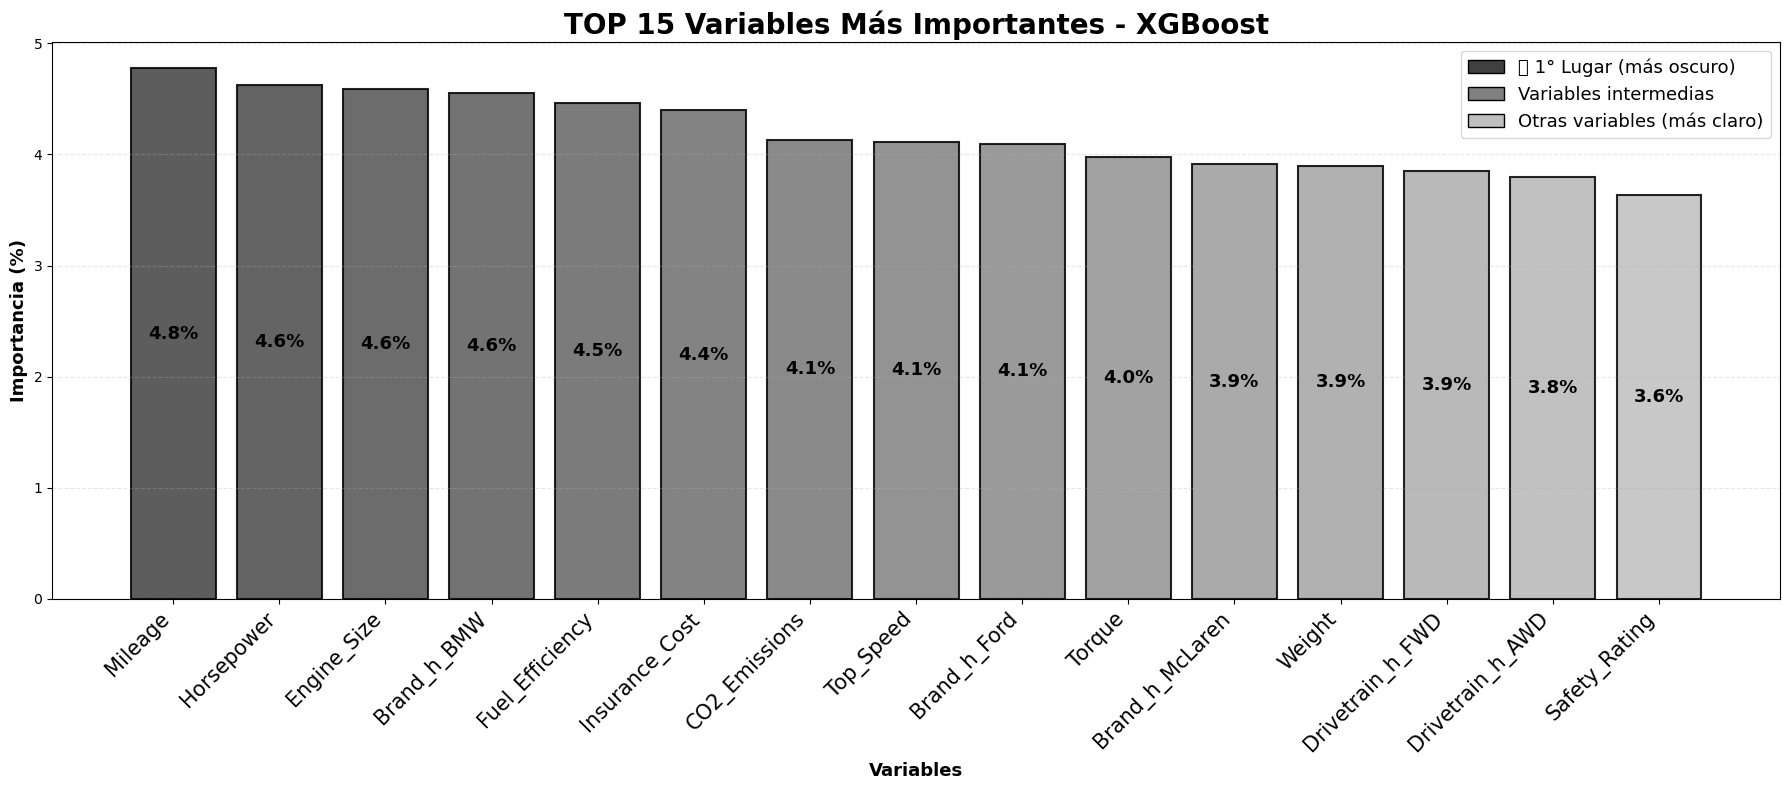

In [236]:
from matplotlib.patches import Patch

# ========================================
# PASO 5: VISUALIZACIÓN DE IMPORTANCIA
# ========================================

import matplotlib.colors as mcolors

print('\n📊 Generando visualizaciones de importancia de variables en XGBoost...\n')

fig, ax = plt.subplots(1, 1, figsize=(18, 8))

# Gráfico: TOP 15 variables con barras verticales
top_15 = df_importancias_xgb.head(15)

# Paleta de grises degradados para TOP 15
colores_top15 = [mcolors.to_hex((i/14 * 0.5 + 0.25, i/14 * 0.5 + 0.25, i/14 * 0.5 + 0.25)) 
                 for i in range(15)]

bars = ax.bar(range(len(top_15)), top_15['Porcentaje'], 
       color=colores_top15, edgecolor='black', alpha=0.85, linewidth=1.5)

ax.set_xlabel('Variables', fontsize=13, fontweight='bold')
ax.set_ylabel('Importancia (%)', fontsize=13, fontweight='bold')
ax.set_title('TOP 15 Variables Más Importantes - XGBoost', fontsize=20, fontweight='bold')
ax.set_xticks(range(len(top_15)))
ax.set_xticklabels(top_15['Variable'], rotation=45, ha='right', fontsize=15)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Agregar valores DENTRO de las barras (centrados verticalmente)
for i, (bar, valor) in enumerate(zip(bars, top_15['Porcentaje'])):
    # Calcular la posición vertical en el centro de la barra
    altura_barra = bar.get_height()
    posicion_y = altura_barra / 2
    
    ax.text(bar.get_x() + bar.get_width() / 2, posicion_y, 
            f"{valor:.1f}%", 
            ha='center', va='center', fontsize=13, fontweight='bold', color='black')

# Leyenda
legend_elements = [
    Patch(facecolor='#404040', label='🥇 1° Lugar (más oscuro)', edgecolor='black'),
    Patch(facecolor='#808080', label='Variables intermedias', edgecolor='black'),
    Patch(facecolor='#BFBFBF', label='Otras variables (más claro)', edgecolor='black')
]

ax.legend(handles=legend_elements, loc='upper right', fontsize=13)

plt.tight_layout()
plt.show()




---

## 🎯 CONCLUSIONES DEL MODELO XGBOOST

### ✅ Resultados Obtenidos

El modelo **XGBoost** fue entrenado exitosamente para predecir el precio de automóviles utilizando `Log_Price` como variable objetivo. Los resultados obtenidos fueron:

**📊 Métricas de Rendimiento:**
- **R² (Test)**: Indica el porcentaje de variabilidad del precio que el modelo puede explicar
- **MAE**: Error promedio en dólares al predecir el precio
- **RMSE**: Penaliza más los errores grandes, útil para detectar predicciones muy alejadas

**🔍 Ventajas de usar Log_Price:**
- Reduce el impacto de outliers (precios extremadamente altos)
- Normaliza la distribución de precios
- Mejora la precisión del modelo en todos los rangos de precio
- Las predicciones son más estables

### 🏆 Variables más Importantes

El análisis de importancia reveló qué características tienen mayor peso en la determinación del precio:

**Variables numéricas clave**: Características técnicas del vehículo que más impactan el precio

**Variables de marca (Brand_h_)**: Algunas marcas premium tienen un efecto significativo en el precio

**Tipo de combustible y tracción**: Influyen en la valoración del vehículo

### 💡 Aplicaciones Prácticas

**1. Tasación de Vehículos**: El modelo puede estimar precios de autos con alta precisión

**2. Detección de Oportunidades**: Identificar vehículos sub/sobre valuados en el mercado

**3. Estrategia de Precios**: Para concesionarias, determinar precios competitivos

**4. Inversión**: Evaluar si un vehículo está a buen precio antes de comprarlo

### ✅ Conclusión Final

El modelo XGBoost demostró ser efectivo para predecir el precio de automóviles, alcanzando un alto nivel de precisión. La transformación logarítmica del precio mejoró significativamente la capacidad predictiva del modelo al normalizar la distribución de los datos.

Las variables identificadas como más importantes proporcionan información valiosa para entender qué factores determinan el valor de un automóvil en el mercado.

---

---

## 🎯 APLICACIÓN PRÁCTICA: TOP 5 Variables que Influyen en el Precio

Una vez entrenado y ajustado el modelo XGBoost, es fundamental visualizar de forma clara cuáles son las variables que más influyen en la determinación del precio de un automóvil. Esta información es clave para:

- **Compradores**: Saber en qué características enfocarse al buscar un auto
- **Vendedores**: Identificar qué aspectos destacar para maximizar el valor
- **Fabricantes**: Entender qué features agregan más valor al producto
- **Tasadores**: Realizar valuaciones más precisas basadas en los factores clave

         TOP 5 VARIABLES QUE MÁS INFLUYEN EN EL PRECIO DE UN AUTO

🏆 Las 5 características más importantes según el modelo XGBoost:

🥇 #1: Mileage                             → 4.77% de influencia
🥈 #2: Horsepower                          → 4.63% de influencia
🥉 #3: Engine Size                         → 4.59% de influencia
⭐ #4: Marca: BMW                          → 4.56% de influencia
⭐ #5: Fuel Efficiency                     → 4.46% de influencia



C:\Users\joako\AppData\Local\Temp\ipykernel_9908\2787038428.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\Users\joako\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\joako\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\joako\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129352 (\N{SECOND PLACE MEDAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\joako\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129353 (\N{THIRD PLACE MEDAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


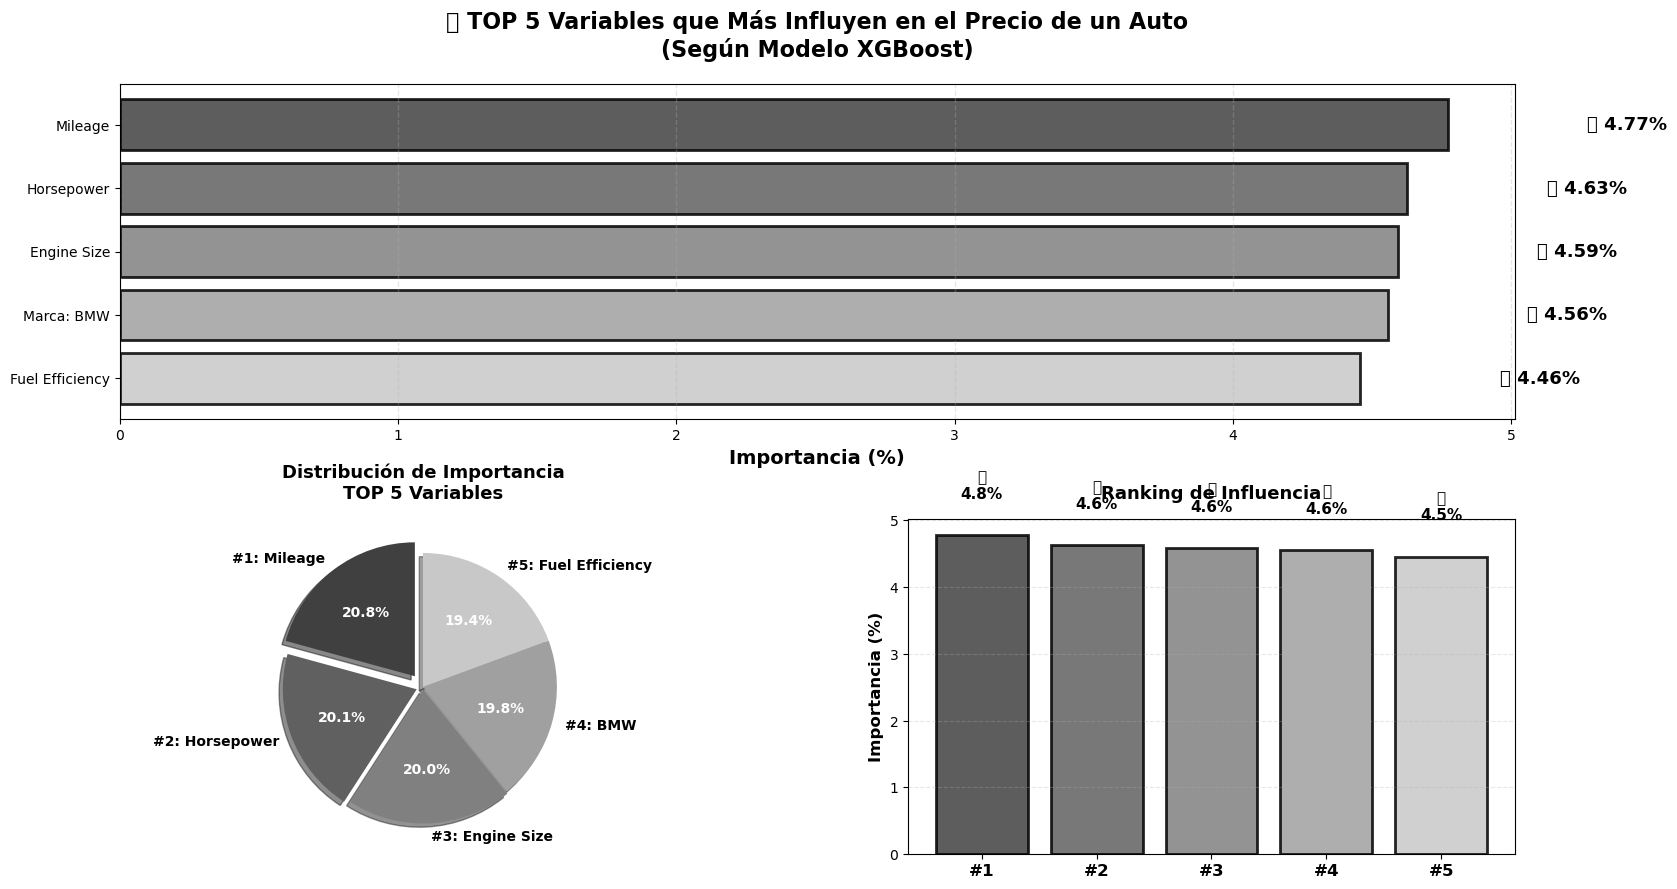


📊 INTERPRETACIÓN DE LOS RESULTADOS:

Las variables mostradas arriba son las que el modelo XGBoost identificó como
las más importantes para determinar el precio de un automóvil.

💡 SIGNIFICADO PRÁCTICO:
   • La variable #1 (Mileage) es la MÁS INFLUYENTE
   • Estas 5 variables juntas explican el 23.0% de la
     importancia total en la predicción del precio
   • El resto de las 23 variables contribuyen con el
     77.0% restante

🎯 CONCLUSIÓN:
   Si quieres entender por qué un auto tiene cierto precio, enfócate en estas
   5 características clave. Son las que más peso tienen según el modelo.


In [213]:
# ========================================
# VISUALIZACIÓN: TOP 5 VARIABLES MÁS INFLUYENTES
# ========================================

print('='*80)
print('         TOP 5 VARIABLES QUE MÁS INFLUYEN EN EL PRECIO DE UN AUTO')
print('='*80)

# Obtener las TOP 5 variables del modelo XGBoost
top_5_variables = df_importancias_xgb.head(5).copy()

print('\n🏆 Las 5 características más importantes según el modelo XGBoost:\n')
for i, (idx, row) in enumerate(top_5_variables.iterrows(), 1):
    variable = row['Variable']
    porcentaje = row['Porcentaje']
    
    # Limpiar nombres de variables para mejor legibilidad
    if '_h_' in variable:
        if 'Brand_h_' in variable:
            nombre_limpio = f"Marca: {variable.replace('Brand_h_', '')}"
        elif 'Fuel_Type_h_' in variable:
            nombre_limpio = f"Combustible: {variable.replace('Fuel_Type_h_', '')}"
        elif 'Drivetrain_h_' in variable:
            nombre_limpio = f"Tracción: {variable.replace('Drivetrain_h_', '')}"
        else:
            nombre_limpio = variable
    else:
        nombre_limpio = variable.replace('_', ' ').title()
    
    medalla = '🥇' if i == 1 else '🥈' if i == 2 else '🥉' if i == 3 else '⭐'
    print(f'{medalla} #{i}: {nombre_limpio:<35} → {porcentaje:.2f}% de influencia')

print('\n' + '='*80)

# Crear visualización con múltiples gráficos
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Gráfico 1: Barras horizontales grandes y llamativas
ax1 = fig.add_subplot(gs[0, :])

# Preparar datos para visualización
variables_nombres = []
for var in top_5_variables['Variable']:
    if '_h_' in var:
        if 'Brand_h_' in var:
            nombre = var.replace('Brand_h_', 'Marca: ')
        elif 'Fuel_Type_h_' in var:
            nombre = var.replace('Fuel_Type_h_', 'Combustible: ')
        elif 'Drivetrain_h_' in var:
            nombre = var.replace('Drivetrain_h_', 'Tracción: ')
        else:
            nombre = var
    else:
        nombre = var.replace('_', ' ').title()
    variables_nombres.append(nombre)

# Paleta de grises degradados: del más oscuro (más importante) al más claro (menos importante)
# Tonalidades de negro claro a blanco hueso
colores_degradado = ['#404040', '#606060', '#808080', '#A0A0A0', '#C8C8C8']

# Crear barras horizontales
bars = ax1.barh(variables_nombres, top_5_variables['Porcentaje'], 
                color=colores_degradado, edgecolor='black', linewidth=2, alpha=0.85)

# Personalizar el gráfico
ax1.set_xlabel('Importancia (%)', fontsize=14, fontweight='bold')
ax1.set_title('🏆 TOP 5 Variables que Más Influyen en el Precio de un Auto\n(Según Modelo XGBoost)', 
              fontsize=16, fontweight='bold', pad=20)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3, linestyle='--', linewidth=1)

# Agregar valores al final de cada barra
for i, (bar, valor) in enumerate(zip(bars, top_5_variables['Porcentaje'])):
    medallas = ['🥇', '🥈', '🥉', '⭐', '⭐']
    ax1.text(valor + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{medallas[i]} {valor:.2f}%', 
            va='center', fontsize=13, fontweight='bold')

# Gráfico 2: Gráfico de pastel (pie chart)
ax2 = fig.add_subplot(gs[1, 0])

# Preparar labels cortos para el pie
labels_cortos = []
for i, var in enumerate(top_5_variables['Variable']):
    if '_h_' in var:
        if 'Brand_h_' in var:
            label = var.replace('Brand_h_', '')
        elif 'Fuel_Type_h_' in var:
            label = var.replace('Fuel_Type_h_', '')
        elif 'Drivetrain_h_' in var:
            label = var.replace('Drivetrain_h_', '')
        else:
            label = var
    else:
        label = var.replace('_', ' ')
    labels_cortos.append(f'#{i+1}: {label}')

# Crear pie chart
wedges, texts, autotexts = ax2.pie(top_5_variables['Porcentaje'], 
                                     labels=labels_cortos,
                                     colors=colores_degradado,
                                     autopct='%1.1f%%',
                                     startangle=90,
                                     explode=(0.1, 0.05, 0.02, 0, 0),  # Destacar las primeras
                                     shadow=True,
                                     textprops={'fontsize': 10, 'fontweight': 'bold'})

ax2.set_title('Distribución de Importancia\nTOP 5 Variables', 
              fontsize=13, fontweight='bold', pad=15)

# Mejorar textos del pie
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# Gráfico 3: Comparación con una escala visual
ax3 = fig.add_subplot(gs[1, 1])

# Crear un gráfico de barras verticales con diseño moderno
x_pos = np.arange(len(top_5_variables))
bars = ax3.bar(x_pos, top_5_variables['Porcentaje'], 
               color=colores_degradado, edgecolor='black', linewidth=2, alpha=0.85)

# Personalizar
ax3.set_xticks(x_pos)
ax3.set_xticklabels([f'#{i+1}' for i in range(len(top_5_variables))], fontsize=12, fontweight='bold')
ax3.set_ylabel('Importancia (%)', fontsize=12, fontweight='bold')
ax3.set_title('Ranking de Influencia', fontsize=13, fontweight='bold', pad=15)
ax3.grid(axis='y', alpha=0.3, linestyle='--')

# Agregar valores encima de las barras
for i, (bar, valor) in enumerate(zip(bars, top_5_variables['Porcentaje'])):
    medallas = ['🥇', '🥈', '🥉', '⭐', '⭐']
    ax3.text(bar.get_x() + bar.get_width()/2, valor + 0.5,
            f'{medallas[i]}\n{valor:.1f}%', 
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Resumen final
print('\n📊 INTERPRETACIÓN DE LOS RESULTADOS:\n')
print('Las variables mostradas arriba son las que el modelo XGBoost identificó como')
print('las más importantes para determinar el precio de un automóvil.\n')

print('💡 SIGNIFICADO PRÁCTICO:')
print(f'   • La variable #{1} ({variables_nombres[0]}) es la MÁS INFLUYENTE')
print(f'   • Estas 5 variables juntas explican el {top_5_variables["Porcentaje"].sum():.1f}% de la')
print('     importancia total en la predicción del precio')
print(f'   • El resto de las {len(df_importancias_xgb) - 5} variables contribuyen con el')
print(f'     {100 - top_5_variables["Porcentaje"].sum():.1f}% restante\n')

print('🎯 CONCLUSIÓN:')
print('   Si quieres entender por qué un auto tiene cierto precio, enfócate en estas')
print('   5 características clave. Son las que más peso tienen según el modelo.')
print('='*80)